# Introduction/Business Problem

My Final Capstone project is to help people who are planning to open a new African restaurant in London. The idea of this capstone project is to help those people to know the best location in London to have a good revenue at the end. The problem that they face is the big area of London which has 8 different areas as following: South East, South West, West, North, East Central, East, West Central, and North West.
At the end of this project, I will determine for them the best area (which one of the 8 areas of London) to be used in London, then I will explore the neighborhoods of that best area in order to have a view of the venue categories and determine the group or groups of neighborhoods to open the restaurant.


# Data Will be Used

To answer those questions, I will get the postcodes of London from wikipedia in order to create the dataframe of London. This dataframe will include different kind of data for example the PostCode, the Name of the Neighborhood, the Area, and the Area Category to determine the 5 areas of London and the process of cleaning the data will be used to clean all venues not included in the PostCode column.
Then, I will be combining the data of current restaurants in London areas with the data will be used from the Foursquare location data to extract the venues information for the areas of interest and grouping the neighborhood in 5 clusters based on different numbers of facilities that are there in that area.
At the end of this project, I will be going to use folium library to create the necessary maps in order to give a visual view to those people of the best location to be used.


# Methodology

In this project, after gathering the required data to built the appropriate dataframe from different data sources as explained above, I will proceed in data analysis to find the best area and neighborhood to open the restaurant. From the Foursquare data I will take into consideration the top common venues in that area, and this can be implemented through frequency statistics and aggregations per area and derive the distributions per area and per venue category. At that point we had to choose the best area of London and we selected the area with the minimum number of restaurants and this will be implemented in two stages the first stage is to selected the top 20 restaurants in the area and the next stage is to select the top 10 restaurant then I will proceed in K-means clustering method in order to group our neighborhoods into 5 clusters based on the venues nearby. Geospatial map view will be used to represent the results. 
The last step is exploring the derived clusters to choose the cluster that there is a probable opportunity to open restaurant after determining the optimal neighborhood based on the least percentage of restaurants and the distance between the new restaurant to other restaurants in the area and other entertainment venues nearby if any.


# Data Analysis and Coding 

In [3]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')


numpy, pandas, ..., imported...
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
folium installed...
folium imported...
...Done


In [4]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [5]:
# Cleans html file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
# This extracts the "tbody" within the table where class is "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [6]:
# Extracts every row with corresponding columns
# Then appends the values to the create pd dataframe "df"
# Please note that the first row (row[0]) is skipped because it is already the header
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [7]:
df.head(5)


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [2]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[3]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[3],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[3],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [8]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [2]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[3]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[3],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[3],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [9]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [10]:
df.shape

(533, 6)

In [11]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [12]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))


In [13]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [14]:
df0.shape

(637, 6)

In [15]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [16]:
df1.shape

(637, 4)

In [18]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]


In [19]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [20]:
df21.shape

(380, 4)

In [21]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [22]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [23]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

In [24]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [25]:
df_london.Postcode = df_london.Postcode.str.strip()

In [26]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [27]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)


In [28]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [33]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [34]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [37]:
demo_london = pd.DataFrame(columns = columns1)

In [38]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [39]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [40]:
demo_london['Black'] = demo_london['Black'].astype('float')


In [41]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)


In [42]:
demo_london_sorted.head(5)


,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


In [43]:
df_se

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [44]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [45]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [46]:
df_se_top.shape

(46, 3)

In [47]:
df_se.shape

(80, 3)

In [48]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [49]:
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

In [50]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

<[OK] Geocodefarm - Reverse [Harrow Manor Way, London, SE2 9, United Kingdom]>

In [51]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  26.214303255081177 seconds


In [52]:
df_se_loc = df_se_top

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [53]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [54]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)


In [55]:
df_se_loc.shape


(46, 5)

In [56]:
CLIENT_ID = 'K2XW1522IS4DLVWIE2QNSO0YDZ1EBFOFSXECQSCLITPYVR5L' 
CLIENT_SECRET = 'QFAGAZDSJ3C145JPPW04A4WF10YVCR24V5JRHWFNDQ11MZBN' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K2XW1522IS4DLVWIE2QNSO0YDZ1EBFOFSXECQSCLITPYVR5L
CLIENT_SECRET:QFAGAZDSJ3C145JPPW04A4WF10YVCR24V5JRHWFNDQ11MZBN


In [57]:
# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [58]:
se_df.shape

(46, 5)

In [59]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49960,-0.09613
6,Elephant and Castle,Southwark,SE11,51.49084,-0.11108
7,Elephant and Castle,Southwark,SE17,51.48764,-0.09542
8,Bankside,Southwark,SE1,51.49960,-0.09613
9,Forest Hill,Lewisham,SE23,51.44122,-0.04764


In [60]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [61]:
se_df.loc[20, 'Location']

'Lewisham'

In [62]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


In [63]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=K2XW1522IS4DLVWIE2QNSO0YDZ1EBFOFSXECQSCLITPYVR5L&client_secret=QFAGAZDSJ3C145JPPW04A4WF10YVCR24V5JRHWFNDQ11MZBN&v=20180605&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [64]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1bbbc6bbf1bd00232780bb'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-535823bc498ec8d8da9aad5f-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_',
          'suffix': '.png'},
         'id': '53e0feef498e5aac066fd8a9',
         'name': 'Street Food Gathering',
         'pluralName': 'Street Food Gatherings',
         'primary': True,
         'shortName': 'Street Food Gathering'}],
       'id': '535823bc498ec8d8da9aad5f',
       'location': {'address': '196 Lewisham High St',
        'cc': 'GB',
        'city': 'Lewisham Central',
        'country': 'United Kingdom',
        'crossStreet': 'entrance at Molesworth St',
        'distance': 377,
        'formattedAddress': ['196 Lewisham High St (entrance at Moleswor

In [65]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [66]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [67]:
nearby_venues

,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Levante restaurant,Restaurant,51.462072,-0.009491
3,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
4,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726
5,Manor House Gardens,Park,51.456686,0.004684
6,Corte,Coffee Shop,51.459776,-0.011554
7,Everest Curry King,Sri Lankan Restaurant,51.466012,-0.019656
8,Blackheath Farmers' Market,Farmers Market,51.465913,0.007945
9,Côte Brasserie,French Restaurant,51.467378,0.007176


In [68]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')


In [69]:
nearby_venues_lewisham_unique.head(5)


,Count
Pub,13
Café,9
Gastropub,6
Park,5
Garden,4


In [70]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


100 venues were returned by Foursquare.


In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [72]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [73]:
se_venues.shape

(4267, 7)

In [74]:
len(se_venues)


4267

In [75]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [76]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant
2,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
3,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
4,Crofton Park,51.46268,-0.03558,waterintobeer,51.463712,-0.038826,Beer Store


In [77]:
se_venues.groupby('Neighbourhood').count()


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,72,72,72,72,72,72
Bermondsey,100,100,100,100,100,100
Blackheath,93,93,93,93,93,93
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,72,72,72,72,72,72
Chinbrook,53,53,53,53,53,53


In [78]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))


There are 195 uniques categories.


In [79]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')


In [80]:
se_venue_unique_count.head(5)


,Count
Pub,428
Coffee Shop,301
Café,295
Park,219
Grocery Store,161


In [81]:
se_venue_unique_count.describe()


,Count
count,195.000000
mean,21.882051
std,49.292745
min,1.000000
25%,4.000000
50%,7.000000
75%,17.000000
max,428.000000


In [82]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [83]:
# df_london_coordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [84]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [85]:
type(se_df)

pandas.core.frame.DataFrame

In [86]:
# one hot encoding
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [87]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [88]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [89]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [90]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]


,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
132,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
655,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
741,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [91]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']


,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1903,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1904,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1905,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [92]:
se_onehot.to_csv('selondon_onehot.csv', index = False)


In [93]:
se_onehot.shape


(4267, 196)

In [94]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.000000,0.0,0.0,0.000000,0.01,0.03,0.0,0.01,0.0,0.0,0.010000,0.030000,0.00,0.0,0.00,0.01,0.01,0.0,0.0,0.000000,0.01,0.02,0.000000,0.010000,0.0,0.01,0.00,0.0,0.01,0.000000,0.0,0.000000,0.020000,0.090000,0.0,0.00,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.01,0.00,0.01,0.01,0.0,0.010000,0.000000,0.000000,0.00,0.010000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.020000,0.010000,0.020000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.0,0.0,0.070000,0.01,0.0,0.01,0.000000,0.00,0.0,0.000000,0.050000,0.000000,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.020000,0.060000,0.00,0.00,0.000000,0.010000,0.0,0.000000,0.000000,0.03,0.0,0.03,0.000000,0.000000,0.01,0.000000,0.000000,0.0,0.01,0.000000,0.0,0.0,0.01,0.0,0.03,0.000000,0.0,0.0,0.02,0.000000,0.05,0.0,0.000000,0.0,0.01,0.000000,0.0,0.000000,0.01,0.0,0.00,0.000000,0.0,0.010000,0.0,0.00,0.00,0.000000
1,Bellingham,0.00,0.000000,0.0,0

In [95]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 196)


In [96]:
se_grouped.to_csv('london_grouped.csv', index = False)


In [97]:
num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                   venue  freq
0            Coffee Shop  0.09
1                  Hotel  0.07
2                    Pub  0.06
3                Theater  0.05
4     Italian Restaurant  0.05
5         Scenic Lookout  0.03
6     Seafood Restaurant  0.03
7                    Bar  0.03
8             Art Museum  0.03
9  Street Food Gathering  0.03


----Bellingham----
                  venue  freq
0         Grocery Store  0.15
1                  Park  0.10
2                  Café  0.07
3           Supermarket  0.07
4                   Pub  0.07
5  Fast Food Restaurant  0.04
6           Coffee Shop  0.04
7           Pizza Place  0.03
8           Gas Station  0.03
9    Italian Restaurant  0.03


----Bermondsey----
                   venue  freq
0            Coffee Shop  0.09
1                  Hotel  0.07
2                    Pub  0.06
3                Theater  0.05
4     Italian Restaurant  0.05
5         Scenic Lookout  0.03
6     Seafood Restaurant  0.03
7                    B

               venue  freq
0                Pub  0.13
1               Café  0.09
2          Gastropub  0.06
3               Park  0.05
4        Coffee Shop  0.04
5             Garden  0.04
6         Food Truck  0.03
7        Supermarket  0.03
8  Fish & Chips Shop  0.03
9     Clothing Store  0.02


----New Cross----
                   venue  freq
0                    Pub  0.14
1            Coffee Shop  0.08
2                   Café  0.07
3     Italian Restaurant  0.04
4                    Bar  0.04
5    Indie Movie Theater  0.03
6                Brewery  0.03
7   Gym / Fitness Center  0.03
8                   Park  0.03
9  Vietnamese Restaurant  0.03


----Newington----
                   venue  freq
0            Coffee Shop  0.09
1                    Pub  0.07
2     Italian Restaurant  0.05
3                  Hotel  0.04
4                Theater  0.04
5                   Café  0.04
6            Pizza Place  0.02
7   Gym / Fitness Center  0.02
8  Street Food Gathering  0.02
9     Seafoo

In [98]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [99]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [100]:
neighbourhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Bar,Art Museum,Street Food Gathering,Scenic Lookout
1,Bellingham,Grocery Store,Park,Supermarket,Café,Pub,Fast Food Restaurant,Coffee Shop,Train Station,Italian Restaurant,Pizza Place
2,Bermondsey,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Bar,Art Museum,Street Food Gathering,Scenic Lookout
3,Blackheath,Pub,Coffee Shop,Grocery Store,Park,Bakery,Café,Italian Restaurant,Garden,French Restaurant,Pizza Place
4,Brixton,Café,Coffee Shop,Park,Pub,Cocktail Bar,Italian Restaurant,Middle Eastern Restaurant,Grocery Store,Pizza Place,Bar


In [101]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)


In [102]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)


In [103]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 1, 4, 1, 4, 3, 2, 1], dtype=int32)

In [104]:
kmeans.labels_[0:10]


array([0, 3, 0, 1, 4, 1, 4, 3, 2, 1], dtype=int32)

In [105]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [106]:
se_merged = se_df

In [107]:
se_merged.head(3)


,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467


In [108]:
# match/merge SE London data with latitude/longitude for each neighborhood
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [109]:
se_merged_latlong.head(5)


,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Pizza Place,Italian Restaurant,Cocktail Bar,Beer Store
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,4,Café,Coffee Shop,Park,Pub,Cocktail Bar,Italian Restaurant,Middle Eastern Restaurant,Grocery Store,Pizza Place,Bar
2,Deptford,Lewisham,SE8,51.48114,-0.02467,1,Pub,Coffee Shop,Café,Bar,Garden,Park,Vietnamese Restaurant,History Museum,Gym / Fitness Center,Italian Restaurant
3,Dulwich,Southwark,SE21,51.44100,-0.08897,1,Pub,Café,Grocery Store,Bakery,Coffee Shop,Park,Italian Restaurant,Brewery,Pizza Place,Farmers Market
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,4,Pub,Café,Pizza Place,Italian Restaurant,Park,Gastropub,Coffee Shop,Burger Joint,Cocktail Bar,Restaurant


In [110]:
se_clusters = se_merged_latlong


In [111]:
%matplotlib inline
import matplotlib
import numpy as np

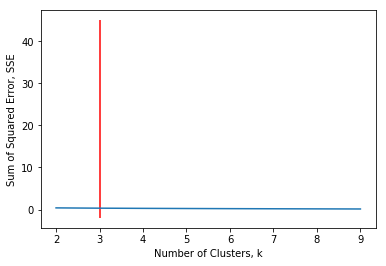

In [112]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

In [113]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6548193378826479
Where n_clusters = 3, the Silhouette Coefficient is 0.6386148144277506
Where n_clusters = 4, the Silhouette Coefficient is 0.6822005169800478
Where n_clusters = 5, the Silhouette Coefficient is 0.7140961431155993
Where n_clusters = 6, the Silhouette Coefficient is 0.7502430993227276
Where n_clusters = 7, the Silhouette Coefficient is 0.7970388219875343
Where n_clusters = 8, the Silhouette Coefficient is 0.8534726183013607
Where n_clusters = 9, the Silhouette Coefficient is 0.9342489314928141


In [114]:
se_clusters.columns


Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [116]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Street Food Gathering,Pizza Place
6,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Street Food Gathering,Pizza Place
7,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Street Food Gathering,Pizza Place
8,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Bar,Art Museum,Street Food Gathering,Scenic Lookout
18,Lambeth,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Bar,Art Museum,Street Food Gathering,Scenic Lookout
22,Southwark,0,Coffee Shop,Pub,Italian Restaurant,Café,Hotel,Theater,Street Food Gathering,Bar,Pizza Place,Park
23,Southwark,0,Coffee Shop,Pub,Italian Restaurant,Café,Hotel,Theater,Street Food Gathering,Bar,Pizza Place,Park
30,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Bar,Art Museum,Street Food Gathering,Scenic Lookout


In [117]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Pizza Place,Italian Restaurant,Cocktail Bar,Beer Store
2,Lewisham,1,Pub,Coffee Shop,Café,Bar,Garden,Park,Vietnamese Restaurant,History Museum,Gym / Fitness Center,Italian Restaurant
3,Southwark,1,Pub,Café,Grocery Store,Bakery,Coffee Shop,Park,Italian Restaurant,Brewery,Pizza Place,Farmers Market
9,Lewisham,1,Pub,Grocery Store,Coffee Shop,Café,Park,Supermarket,Indian Restaurant,Gym / Fitness Center,Forest,Convenience Store
10,Lambeth,1,Pub,Coffee Shop,Park,Café,Grocery Store,Italian Restaurant,Bakery,Train Station,Breakfast Spot,Pizza Place
11,Lambeth,1,Pub,Coffee Shop,Park,Café,Grocery Store,Italian Restaurant,Bakery,Train Station,Breakfast Spot,Pizza Place
14,Lewisham,1,Pub,Café,Gastropub,Park,Coffee Shop,Garden,Supermarket,Fish & Chips Shop,Food Truck,Bar
15,Lewisham,1,Pub,Grocery Store,Coffee Shop,Café,Park,Supermarket,Indian Restaurant,Gym / Fitness Center,Forest,Convenience Store
16,Lewisham,1,Pub,Café,Coffee Shop,Park,Gastropub,Bar,Food Truck,Italian Restaurant,Supermarket,Fish & Chips Shop
17,Lewisham,1,Pub,Café,Coffee Shop,Park,Gastropub,Bar,Food Truck,Italian Restaurant,Supermarket,Fish & Chips Shop


In [118]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,2,Grocery Store,Pub,Park,Café,Gym / Fitness Center,Italian Restaurant,Supermarket,Coffee Shop,Train Station,Hotel
19,Lewisham,2,Grocery Store,Pub,Park,Café,Gym / Fitness Center,Italian Restaurant,Supermarket,Coffee Shop,Train Station,Hotel
45,Lewisham,2,Grocery Store,Pub,Park,Café,Gym / Fitness Center,Italian Restaurant,Supermarket,Coffee Shop,Train Station,Hotel


In [119]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Lewisham,3,Grocery Store,Park,Supermarket,Café,Pub,Fast Food Restaurant,Coffee Shop,Train Station,Italian Restaurant,Pizza Place
29,Croydon,3,Grocery Store,Pub,Supermarket,Park,Café,Coffee Shop,Chinese Restaurant,Gas Station,Platform,Hotel
31,Croydon,3,Grocery Store,Pub,Supermarket,Park,Café,Coffee Shop,Chinese Restaurant,Gas Station,Platform,Hotel
32,Lewisham,3,Grocery Store,Park,Supermarket,Café,Pub,Fast Food Restaurant,Coffee Shop,Train Station,Italian Restaurant,Pizza Place
44,Lewisham,3,Grocery Store,Park,Supermarket,Café,Pub,Fast Food Restaurant,Coffee Shop,Train Station,Italian Restaurant,Pizza Place


In [120]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,4,Café,Coffee Shop,Park,Pub,Cocktail Bar,Italian Restaurant,Middle Eastern Restaurant,Grocery Store,Pizza Place,Bar
4,Southwark,4,Pub,Café,Pizza Place,Italian Restaurant,Park,Gastropub,Coffee Shop,Burger Joint,Cocktail Bar,Restaurant
13,Lambeth,4,Coffee Shop,Pub,Café,Pizza Place,Brewery,Market,Restaurant,Cocktail Bar,Park,Indie Movie Theater
24,Southwark,4,Pub,Café,Pizza Place,Park,Italian Restaurant,Coffee Shop,Bar,Gastropub,Indie Movie Theater,Art Gallery
25,Lambeth,4,Café,Park,Hotel,Theater,Pub,Coffee Shop,Bar,Art Gallery,Cricket Ground,Gay Bar
27,Southwark,4,Pub,Café,Pizza Place,Park,Italian Restaurant,Coffee Shop,Bar,Gastropub,Indie Movie Theater,Art Gallery
28,Southwark,4,Pub,Brewery,Bar,Park,Coffee Shop,Vietnamese Restaurant,Bakery,Gym / Fitness Center,Café,English Restaurant
34,Southwark,4,Pub,Brewery,Bar,Park,Coffee Shop,Vietnamese Restaurant,Bakery,Gym / Fitness Center,Café,English Restaurant
35,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Bakery,Brewery,Gym / Fitness Center,Italian Restaurant
36,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Bakery,Brewery,Gym / Fitness Center,Italian Restaurant


# Discussion


To conclude the observation while working on this project in order to determine the best area to open the restaurant in London, I can summary the observation as following:   
•	There were lots of restaurants and food industries in London.  
•	 There were lots of special non geolocation postcodes that correspond to food and other facilities in the data.  
•	Many factories used in this project to determine the best location/area to open the restaurant such as the number of food restaurants nearby, distance from central London and if there are other facility venues nearby. 


# Result

The following are the results from analyzing the above 5 clusters :  

1. Pubs, Cafe, Coffee Shops are popular shops in the South East London.
2. The Italian Restaurants are very popular in the South East London area (Especially in Southwark and Lambeth areas).
3. Lewisham area is the most condensed area of Africans in the South East Area.


# Conclusion

From the results we can conclude that Clusters 2 and 3 are the most viable clusters to create an African Restaurant. Their proximity to other amenities and accessibility to station are paramount. The proximity to resources needed is paramount as Lewisham and Lambeth are not far out from Peckham (under Southwark).
More factors can affect the results if included in this project, for example, more facilities near the area we will open the African restaurant, the traffic access, hotels, and also the feed back of people on other African restaurants if any. 
